In [33]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [34]:
import tensorflow as tf

In [35]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [36]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
mainDIR = (os.listdir("../input/chest-xray-pneumonia/chest_xray"))
print(mainDIR)

['chest_xray', '__MACOSX', 'train', 'val', 'test']


In [38]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train/"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test/"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val/"

In [39]:
#train
os.listdir(train_dir)
train_n = train_dir + "NORMAL"
train_p = train_dir + "PNEUMONIA"

Normal Picture Title:  IM-0209-0001.jpeg
Pneumonia Picture Title:  person1484_virus_2576.jpeg


Text(0.5, 1.0, 'Pneumonia')

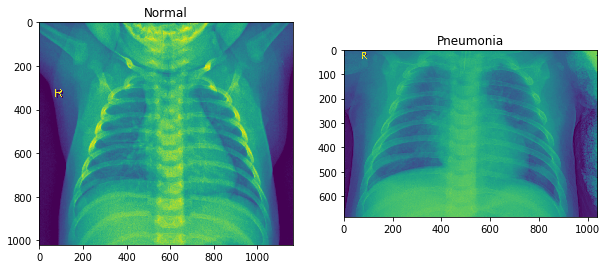

In [40]:
#normal
rand_norm = np.random.randint(0,(len(os.listdir(train_n))))
norm_pic = os.listdir(train_n)[rand_norm]
print("Normal Picture Title: ", norm_pic)
norm_pic_address = (train_n + '/' + norm_pic)

#pneumonia
rand_pne = np.random.randint(0,(len(os.listdir(train_p))))
pne_pic = os.listdir(train_p)[rand_pne]
print("Pneumonia Picture Title: ", pne_pic)
pne_pic_address = (train_p + '/' + pne_pic)

norm_load = Image.open(norm_pic_address)
pne_load = Image.open(pne_pic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pne_load)
a2.set_title('Pneumonia')

In [41]:
img_size = 64

In [53]:
#image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.3, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/train/", target_size = (img_size,img_size), batch_size=32, class_mode='binary', shuffle=True)
validation_generator = test_datagen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/val/", target_size = (img_size,img_size), batch_size=32, class_mode='binary', shuffle=True)
test_set = test_datagen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/test/", target_size = (img_size,img_size), batch_size=32, class_mode='binary',shuffle=True)

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels=[]

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(test_dir + cond)):
        img = plt.imread(test_dir+cond+img)
        img = cv2.resize(img, (img_size,img_size))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label=0
        elif cond=='/PNEUMONIA/':
            label=1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
    

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [43]:
#Input Layer
inputs = Input(shape=(img_size, img_size, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#second conv block
x = SeparableConv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#third conv block
x = SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

#output layer
output = Dense(units=1, activation='sigmoid')(x)

#creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [44]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 64, 64, 256)       1051      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 262144)            0   

In [45]:
batch_size = 32
cnn_model = model.fit_generator(training_set, steps_per_epoch=(training_set.samples//batch_size), 
                                epochs=10, validation_data = validation_generator, 
                                validation_steps=(validation_generator.samples//batch_size), 
                                callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 70s 427ms/step - loss: 0.9989 - accuracy: 0.7053 - val_loss: 0.7720 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 68s 415ms/step - loss: 0.4550 - accuracy: 0.7939 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 68s 414ms/step - loss: 0.4088 - accuracy: 0.8227 - val_loss: 0.8284 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 68s 417ms/step - loss: 0.3979 - accuracy: 0.8269 - val_loss: 0.8478 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 67s 413ms/step - loss: 0.3636 - accuracy: 0.8464 - val_loss: 0.5744 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 68s 419ms/step - loss: 0.3498 - accuracy: 0.8459 - val_loss: 0.7887 - val_accuracy: 0.5625

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/10
163/163 [=============================

In [46]:
history_dict = cnn_model.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

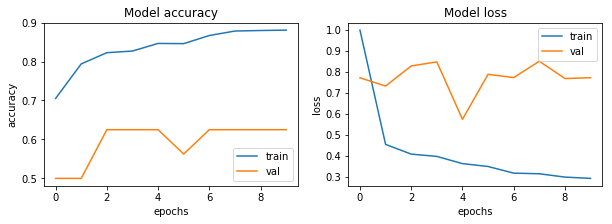

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(cnn_model.history[met])
    ax[i].plot(cnn_model.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train' , 'val'])

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((cnn_model.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[160  74]
 [ 18 372]]

TEST METRICS ----------------------
Accuracy: 85.25641025641025%
Precision: 83.40807174887892%
Recall: 95.38461538461539%
F1-score: 88.99521531100477

TRAIN METRIC ----------------------


KeyError: 'acc'